In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

In [5]:
data = pd.read_pickle("USStockData.pickle")
res = []
lis = data.keys()

for item in lis:
    temp = data[item].close
    temp = temp.to_frame()
    temp.columns = [item]
    res.append(temp)

In [6]:
df = pd.concat(res,axis=1)

In [18]:
data_eu = pd.read_pickle("EU_data.pickle")


{'OR FP Equity':                       ID CURRENCY    Open    High     Low   Close
 DATE                                                             
 2010-01-04  OR FP Equity      EUR   78.20   79.85   78.20   79.83
 2010-01-05  OR FP Equity      EUR   79.43   79.72   78.13   78.56
 2010-01-06  OR FP Equity      EUR   78.57   78.91   77.83   77.87
 2010-01-07  OR FP Equity      EUR   77.94   78.24   76.92   78.08
 2010-01-08  OR FP Equity      EUR   78.59   78.59   77.48   77.69
 ...                  ...      ...     ...     ...     ...     ...
 2019-12-23  OR FP Equity      EUR  264.60  266.70  263.50  265.30
 2019-12-24  OR FP Equity      EUR  265.30  265.30  263.20  264.50
 2019-12-27  OR FP Equity      EUR  264.90  267.60  263.50  266.10
 2019-12-30  OR FP Equity      EUR  265.90  266.20  263.20  263.20
 2019-12-31  OR FP Equity      EUR  262.80  264.60  261.70  264.00
 
 [2559 rows x 6 columns],
 'DG FP Equity':                       ID CURRENCY    Open    High     Low   Close
 D

In [10]:
data_last = df[df.index>'2016-01-01']

In [15]:
data_last.to_csv("USStockClose.csv")

In [22]:
# Parameters Setting
initial_budget = 10000
n_stocks = 10
trading_cost = 0.0/1000
lookback = 120
rebalance = 20
risk_aversion = 1

C:\ProgramData\Anaconda3\envs\Pricing\lib\site-packages\numpy\core\_methods.py:275: FutureWarning: In a future version, DataFrame.max(axis=None) will return a scalar max over the entire DataFrame. To retain the old behavior, use 'frame.max(axis=0)' or just 'frame.max()'
  umr_maximum(a, axis, None, out, keepdims),
C:\ProgramData\Anaconda3\envs\Pricing\lib\site-packages\numpy\core\_methods.py:276: FutureWarning: In a future version, DataFrame.min(axis=None) will return a scalar min over the entire DataFrame. To retain the old behavior, use 'frame.min(axis=0)' or just 'frame.min()'
  umr_minimum(a, axis, None, None, keepdims),


Annualized Return:  13.54234407753532 %
Annualized Volatility:  18.890774386197737 %
Downside Deviation:  13.841169134008846 %
Max Drawdown(in percentage):  42.54349108597082 %
Max Drawdown(in dollars):  5563.630000000001
Sharpe Ratio:  0.7168760687454842
Sortino Ratio:  0.9784104179653951


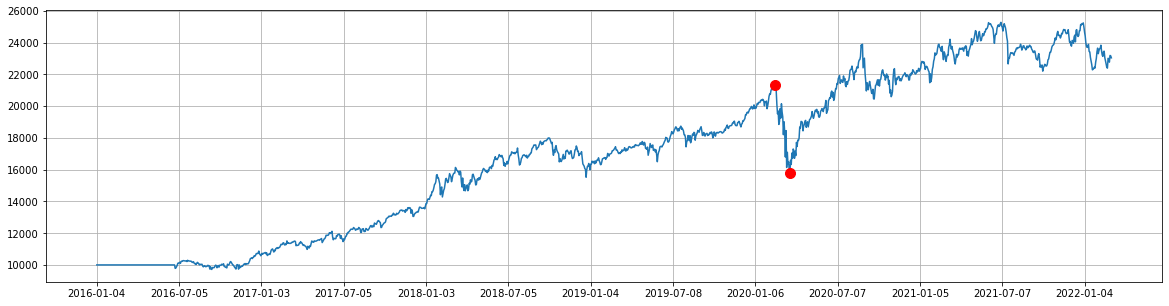

In [23]:

net_value = pd.DataFrame([0]*data_last.shape[0], index=data_last.index, columns=['net_value'])
cash = pd.DataFrame([0]*data_last.shape[0], index=data_last.index,columns=['cash'])
# Target Weight
weight = pd.DataFrame(np.zeros(shape=data_last.shape),columns=data_last.columns, index=data_last.index)
# Practical Position
stock_pos = pd.DataFrame(np.zeros(shape=data_last.shape),columns=data_last.columns, index=data_last.index)



for i in range(0,lookback):
    cash.iloc[i] = initial_budget
    net_value.iloc[i] = initial_budget


for i in range(lookback, data_last.shape[0]):
#for i in range(lookback, 160):
    today_price = data_last.iloc[i-1:i+1]
    today_ret = (today_price - today_price.shift()).iloc[1:]/today_price.shift().iloc[1]
    today_ret = today_ret.fillna(0)
    if (i-lookback)%20 == 0:
        temp = data_last.iloc[i-lookback:i-1].dropna(axis=1)
        temp_ret = (np.log(temp)).diff()[1:]
        ret = temp_ret.sum(axis=0)
        vol = temp_ret.std(axis=0)
        momentum = ret - risk_aversion * vol
        if (momentum.shape[0] >= n_stocks):
            idx_buy = momentum.nlargest(n_stocks).index
            weight.iloc[i][idx_buy] = 1.0/n_stocks
        else:
            n_mom = momentum.shape[0]
            idx_buy = momentum.nlargest(n_mom).index
            weight.iloc[i][idx_buy] = 1.0/n_mom
        if i > lookback:
            cash.iloc[i] = stock_pos.iloc[i-1][idx_pre].sum()*(1-trading_cost)+cash.iloc[i-1]
        else:
            cash.iloc[i] = cash.iloc[i-1]

        available_cash = cash.iloc[i].values[0]
        for stock_id in idx_buy:
            target_pos = weight.iloc[i][stock_id]*available_cash
            n_temp = np.floor(target_pos/(data_last.iloc[i-1][stock_id]*(1+trading_cost)))
            stock_pos.iloc[i][stock_id] = n_temp*data_last.iloc[i-1][stock_id]
            cash.iloc[i] -= n_temp*data_last.iloc[i-1][stock_id]*(1+trading_cost)
        stock_pos.iloc[i] = stock_pos.iloc[i] *(today_ret[stock_pos.columns]+1)
        idx_pre = idx_buy
    else:
        weight.iloc[i] = weight.iloc[i-1]
        stock_pos.iloc[i] = stock_pos.iloc[i-1]*(today_ret[stock_pos.columns]+1)
        cash.iloc[i] = cash.iloc[i-1]
    net_value.iloc[i] = cash.iloc[i] + sum(stock_pos.iloc[i])


ret = np.log(net_value).diff().dropna()
annual_ret = ret.mean().values[0]*252
annual_vol = ret.std().values[0]*np.sqrt(252)
sharpe = annual_ret/annual_vol
s=(ret+1).cumprod()
mdd_pct = (1-np.ptp(s)/s.max()).values[0]
mdd_usd = (net_value.cummax()-net_value).max()
mdd_usd = mdd_usd.values[0]
r_d = ret[ret<0].dropna()
down_deviation = np.sqrt(252)*(np.sqrt((0 - r_d)**2).sum())/r_d.shape[0]
down_deviation = down_deviation.values[0]
sortino = annual_ret/ down_deviation

print("Annualized Return: ", annual_ret*100, "%")
print("Annualized Volatility: ", annual_vol*100, "%")
print("Downside Deviation: ", down_deviation*100, "%")
print("Max Drawdown(in percentage): ", mdd_pct*100, "%")
print("Max Drawdown(in dollars): ", mdd_usd)
print("Sharpe Ratio: ", sharpe)
print("Sortino Ratio: ", sortino)


fig = plt.figure(figsize=(20,5))
ax = fig.add_subplot(111)
i = np.argmax(np.maximum.accumulate(net_value) - net_value) # end of the period
j = np.argmax(net_value[:i]) # start of period
ax.plot(net_value)
ax.plot([net_value.index[i], net_value.index[j]], [net_value.iloc[i], net_value.iloc[j]], 'o', color='Red', markersize=10)
tick_space = 126
ax.xaxis.set_major_locator(ticker.MultipleLocator(tick_space))
plt.grid()
plt.show()

In [14]:
stock_pos

,MSFT,AAPL,AMZN,FB,GOOG,JNJ,JPM,V,PG,T,...,NEE,MDT,ABBV,PYPL,AMGN,TMO,LLY,HON,ACN,IBM
2016-01-04,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2016-01-05,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2016-01-06,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2016-01-07,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2016-01-08,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-02-28,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2022-03-01,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2022-03-02,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2022-03-03,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [26]:
def mom(data, nitial_budget = 10000, n_stocks = 1, trading_cost = 0.0/1000, lookback = 120, rebalance = 20, risk_aversion = 1):
    net_value = pd.DataFrame([0]*data_last.shape[0], index=data_last.index, columns=['net_value'])
    cash = pd.DataFrame([0]*data_last.shape[0], index=data_last.index,columns=['cash'])
    # Target Weight
    weight = pd.DataFrame(np.zeros(shape=data_last.shape),columns=data_last.columns, index=data_last.index)
    # Practical Position
    stock_pos = pd.DataFrame(np.zeros(shape=data_last.shape),columns=data_last.columns, index=data_last.index)



    for i in range(0,lookback):
        cash.iloc[i] = initial_budget
        net_value.iloc[i] = initial_budget


    for i in range(lookback, data_last.shape[0]):
    #for i in range(lookback, 160):
        today_price = data_last.iloc[i-1:i+1]
        today_ret = (today_price - today_price.shift()).iloc[1:]/today_price.shift().iloc[1]
        today_ret = today_ret.fillna(0)
        if (i-lookback)%20 == 0:
            temp = data_last.iloc[i-lookback:i-1].dropna(axis=1)
            temp_ret = (np.log(temp)).diff()[1:]
            ret = temp_ret.sum(axis=0)
            vol = temp_ret.std(axis=0)
            momentum = ret - risk_aversion * vol
            if (momentum.shape[0] >= n_stocks):
                idx_buy = momentum.nlargest(n_stocks).index
                weight.iloc[i][idx_buy] = 1.0/n_stocks
            else:
                n_mom = momentum.shape[0]
                idx_buy = momentum.nlargest(n_mom).index
                weight.iloc[i][idx_buy] = 1.0/n_mom
            if i > lookback:
                cash.iloc[i] = stock_pos.iloc[i-1][idx_pre].sum()*(1-trading_cost)+cash.iloc[i-1]
            else:
                cash.iloc[i] = cash.iloc[i-1]

            available_cash = cash.iloc[i].values[0]
            for stock_id in idx_buy:
                target_pos = weight.iloc[i][stock_id]*available_cash
                n_temp = np.floor(target_pos/(data_last.iloc[i-1][stock_id]*(1+trading_cost)))
                stock_pos.iloc[i][stock_id] = n_temp*data_last.iloc[i-1][stock_id]
                cash.iloc[i] -= n_temp*data_last.iloc[i-1][stock_id]*(1+trading_cost)
            stock_pos.iloc[i] = stock_pos.iloc[i] *(today_ret[stock_pos.columns]+1)
            idx_pre = idx_buy
        else:
            weight.iloc[i] = weight.iloc[i-1]
            stock_pos.iloc[i] = stock_pos.iloc[i-1]*(today_ret[stock_pos.columns]+1)
            cash.iloc[i] = cash.iloc[i-1]
        net_value.iloc[i] = cash.iloc[i] + sum(stock_pos.iloc[i])

    net_value/=initial_budget
    ret = np.log(net_value).diff().dropna()
    annual_ret = ret.mean().values[0]*252
    annual_vol = ret.std().values[0]*np.sqrt(252)
    sharpe = annual_ret/annual_vol
    s=(ret+1).cumprod()
    mdd_pct = (1-np.ptp(s)/s.max()).values[0]
    mdd_usd = (net_value.cummax()-net_value).max()
    mdd_usd = mdd_usd.values[0]
    r_d = ret[ret<0].dropna()
    down_deviation = np.sqrt(252)*(np.sqrt((0 - r_d)**2).sum())/r_d.shape[0]
    down_deviation = down_deviation.values[0]
    sortino = annual_ret/ down_deviation

    print("Annualized Return: ", annual_ret*100, "%")
    print("Annualized Volatility: ", annual_vol*100, "%")
    print("Downside Deviation: ", down_deviation*100, "%")
    print("Max Drawdown(in percentage): ", mdd_pct*100, "%")
    print("Max Drawdown(in dollars): ", mdd_usd)
    print("Sharpe Ratio: ", sharpe)
    print("Sortino Ratio: ", sortino)


    fig = plt.figure(figsize=(20,5))
    ax = fig.add_subplot(111)
    i = np.argmax(np.maximum.accumulate(net_value) - net_value) # end of the period
    j = np.argmax(net_value[:i]) # start of period
    ax.plot(net_value)
    ax.plot([net_value.index[i], net_value.index[j]], [net_value.iloc[i], net_value.iloc[j]], 'o', color='Red', markersize=10)
    tick_space = 126
    ax.xaxis.set_major_locator(ticker.MultipleLocator(tick_space))
    plt.grid()
    plt.show()

C:\ProgramData\Anaconda3\envs\Pricing\lib\site-packages\numpy\core\_methods.py:275: FutureWarning: In a future version, DataFrame.max(axis=None) will return a scalar max over the entire DataFrame. To retain the old behavior, use 'frame.max(axis=0)' or just 'frame.max()'
  umr_maximum(a, axis, None, out, keepdims),
C:\ProgramData\Anaconda3\envs\Pricing\lib\site-packages\numpy\core\_methods.py:276: FutureWarning: In a future version, DataFrame.min(axis=None) will return a scalar min over the entire DataFrame. To retain the old behavior, use 'frame.min(axis=0)' or just 'frame.min()'
  umr_minimum(a, axis, None, None, keepdims),


Annualized Return:  31.116476098345565 %
Annualized Volatility:  36.136673867480965 %
Downside Deviation:  25.392843850312772 %
Max Drawdown(in percentage):  17.166464806345772 %
Max Drawdown(in dollars):  2.385027
Sharpe Ratio:  0.8610774808012137
Sortino Ratio:  1.2254033570155747


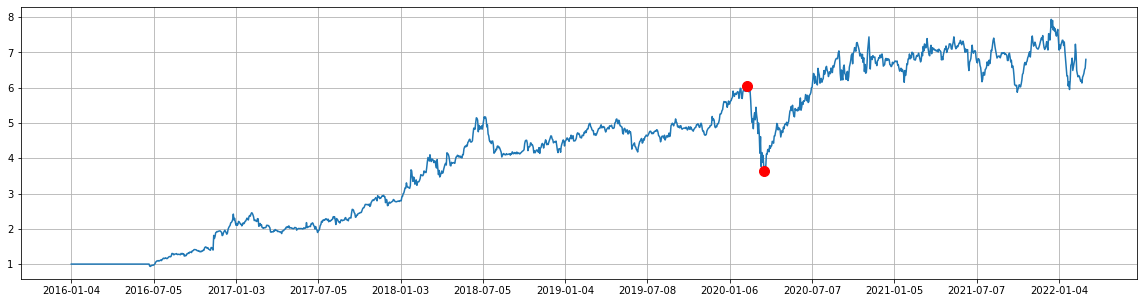

In [27]:
mom(data_last)